**Upgrade the Python package manager**

**Installs the Hugging Face Transformers library along with the PyTorch dependencies and the Datasets library. The '-q' flag is used to suppress the output and make the installation process less verbose.**

In [1]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cu

In [2]:
import os
import re
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
from datasets import Dataset, DatasetDict
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import torchvision.transforms as transforms
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**is used to determine the device on which PyTorch should perform computation**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from datasets import Dataset, DatasetDict, Features, Value, Image
import pandas as pd
import os

def path_vqa_style_setup(path_project):
    import os
    import pandas as pd
    from datasets import Dataset, DatasetDict, Features, Value, Image

    # 1) Load the dataset
    file_name = "VQA_RAD Dataset Public.json"
    image_folder_name = "VQA_RAD Image Folder"
    json_path = os.path.join(path_project, file_name)
    image_folder_path = os.path.join(path_project, image_folder_name)

    df = pd.read_json(json_path)
    print("Original rows:", len(df))

    # 2) Normalize text fields
    df['answer_type'] = df['answer_type'].str.strip().str.lower()
    df['question_type'] = df['question_type'].str.strip().str.lower()
    df['answer'] = df['answer'].str.strip().str.lower()

    # 3) Filter to closed-type questions
    df_closed = df[df['answer_type']=='closed'].copy()
    print("Closed-QA rows:", len(df_closed))

    # 4) Construct full image paths
    df_closed['image_path'] = df_closed['image_name'].apply(lambda x: os.path.join(image_folder_path, x))

    # 5) Keep only rows with existing image files
    df_closed['image_exists'] = df_closed['image_path'].apply(os.path.exists)
    df_closed = df_closed[df_closed['image_exists']]
    print("Images found:", len(df_closed))

    # 6) Original closed-QA (organ column will be NaN here)
    df_closed_qa = df_closed[['image_path', 'question', 'answer']].copy()
    df_closed_qa['image_organ'] = pd.NA

    # 7) Build the "template" for organ & question_type
    df_present = (
        df_closed[['image_path', 'image_organ', 'question_type']]  # include question_type
        .drop_duplicates(subset='image_path')
        .copy()
    )

    # 8a) QA variant #1: ask about the question type
    df_q1 = df_present.assign(
        question = "What is the type of the question?",
        answer = df_present['question_type']
    )[['image_path', 'question', 'answer', 'image_organ']]

    # 8b) QA variant #2: ask about the organ
    df_q2 = df_present.assign(
        question = "Which organ is shown?",
        answer = df_present['image_organ']
    )[['image_path', 'question', 'answer', 'image_organ']]

    # 9) Combine all three sets and shuffle
    df_all = pd.concat([df_closed_qa, df_q1, df_q2], ignore_index=True)
    df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
    print("Total QA rows:", len(df_all))

    if df_all.empty:
        print("No valid image-question-answer rows!")
        return DatasetDict({
            'train': Dataset.from_dict({}),
            'validation': Dataset.from_dict({}),
            'test': Dataset.from_dict({})
        })

    # 10) Rename column for compatibility with features schema
    df_all = df_all.rename(columns={"image_path": "image"})

    # 11) Keep only the necessary columns
    df_all = df_all[['image', 'question', 'answer']]

    # 12) Train/Val/Test Split
    total = len(df_all)
    train_end = int(0.8 * total)
    val_end = int(0.9 * total)
    train_df = df_all.iloc[:train_end]
    val_df = df_all.iloc[train_end:val_end]
    test_df = df_all.iloc[val_end:]

    # 13) Set features
    features = Features({
        "image": Image(),  # Will load automatically later
        "question": Value("string"),
        "answer": Value("string")
    })

    # 14) Create dataset dictionaries with matching schema
    def create_dataset_dict(df):
        result = {
            "image": df["image"].tolist(),
            "question": df["question"].tolist(),
            "answer": df["answer"].tolist()
        }
        return result

    # 15) Build datasets using from_dict to ensure schema matching
    train_dict = create_dataset_dict(train_df)
    val_dict = create_dataset_dict(val_df)
    test_dict = create_dataset_dict(test_df)

    train_ds = Dataset.from_dict(train_dict, features=features)
    val_ds = Dataset.from_dict(val_dict, features=features)
    test_ds = Dataset.from_dict(test_dict, features=features)

    return DatasetDict({
        'train': train_ds,
        'validation': val_ds,
        'test': test_ds
    })


In [5]:
#from google.colab import drive
#drive.mount('/content/drive')
path_project = '/content/drive/MyDrive/Project/'
dataset = path_vqa_style_setup(path_project)

Original rows: 2248
Closed-QA rows: 1299
Images found: 1299
Total QA rows: 1899


Q: Which organ is shown?
A: ABD


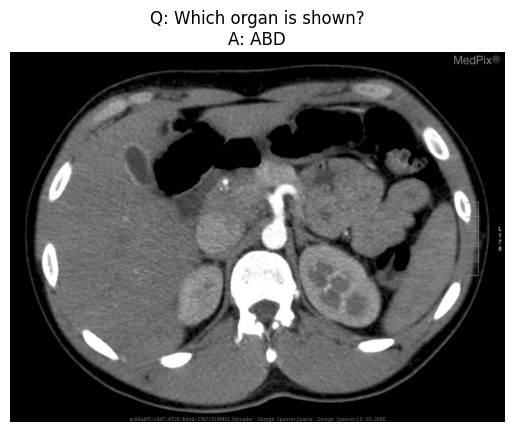

In [6]:


# Check one sample
sample = dataset['train'][10]

# Show question & answer
print("Q:", sample['question'])
print("A:", sample['answer'])

# Show image
import matplotlib.pyplot as plt
plt.imshow(sample['image'])  # No need to convert now
plt.axis('off')
plt.title(f"Q: {sample['question']}\nA: {sample['answer']}")
plt.show()

**The dataset downloaded and named after dataset1, the below cell stores the dataset1 in the name of dataset so, we can run the below cell any time without downloading the dataset again and again if any changes we made to the dataset**

**use the below cell for formating your dataset according to you ' train_test_split ' ratio**

**Use the below joblib format dataset for main model development**

In [7]:
def max_dataset(data):
    max = 0
    for question in data:
        k = len(question.split( ))
        if(k>max):
            max = k
    return max


train_dataset = dataset['train']
test_dataset = dataset['test']
validation_dataset = dataset['validation']

questions_train = train_dataset['question']
question_test = test_dataset['question']
question_validation = validation_dataset['question']


print(f"Max question length in train : {max_dataset(questions_train)}")
print(f"Max question length in test : {max_dataset(question_test)}")
print(f"Max question length in validation : {max_dataset(question_validation)}")


Max question length in train : 19
Max question length in test : 21
Max question length in validation : 21


In [8]:
!pip install transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 127.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.31.0 which is incompatible.


In [9]:
from PIL import Image as PILImage  # ← disambiguate
import matplotlib.pyplot as plt
import numpy as np
from transformers import BlipProcessor, BlipImageProcessor, BlipForQuestionAnswering, BlipConfig

In [10]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")
config.text_config.hidden_dropout_prob = 0.3
config.text_config.attention_probs_dropout_prob = 0.3
config.vision_config.dropout = 0.3
config.vision_config.attention_dropout = 0.3
config

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

BlipConfig {
  "_commit_hash": "787b3d35d57e49572baabd22884b3d5a05acf072",
  "architectures": [
    "BlipForQuestionAnswering"
  ],
  "image_text_hidden_size": 256,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "logit_scale_init_value": 2.6592,
  "model_type": "blip",
  "projection_dim": 512,
  "text_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.3,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 30522,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_hidden_size": 768,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
  

**Splitting the dataset into training, validation, and test sets. The provided code assigns different subsets of the dataset to variables train_data, val_data, and test_data.**

In [11]:
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [12]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Train data size: 1519
Validation data size: 190
Test data size: 190


In [13]:

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]


        image_encoding= self.image_processor(image,
                                do_resize=True,
                                size=(224,224),
                                return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding
print("end")

end


In [14]:
from transformers import BlipProcessor, BlipImageProcessor,BlipForQuestionAnswering
import torch

text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")





preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [15]:
train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=train_data,
                     segment='validation',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )
print("Instance Created")

Instance Created


In [16]:
from torch.utils.data import DataLoader

In [27]:

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=32,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=32,
                            shuffle=False)
print("Collate")

Collate


In [18]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 224, 224])
labels torch.Size([64, 32])


In [19]:
#BLIP_Model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base" )
BLIP_Model = BlipForQuestionAnswering.from_pretrained(
    "Salesforce/blip-vqa-base",
    config=config  # ← this applies your dropout settings
)

BLIP_Model.to(device)

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.3, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [20]:
optimizer = torch.optim.AdamW(BLIP_Model.parameters(), lr=5e-5)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

In [21]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print()
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
#plt.imshow(Image.fromarray(unnormalized_image))

Question:  [CLS] is there evidence of pneumoperitoneum? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Answer:  [CLS] yes [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch

In [30]:
import torch
  torch.cuda.empty_cache()

IndentationError: unexpected indent (<ipython-input-30-163e86978433>, line 2)

In [28]:
import tqdm
import torch
from tqdm import tqdm
num_epochs = 7
BLIP_Model.train()



for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    total_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = BLIP_Model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model_save_path = f"/content/drive/MyDrive/BLIP_Model_epoch{epoch + 1}.pt"
    torch.save(BLIP_Model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")
    print(f"Average Loss: {total_loss / len(train_dataloader):.4f}")

Epoch 1/7


Training Epoch 1:   2%|▏         | 1/48 [00:02<02:02,  2.60s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 6.88 MiB is free. Process 20355 has 39.54 GiB memory in use. Of the allocated memory 38.62 GiB is allocated by PyTorch, and 428.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def predictions(model_name,no_of_predictions):
    # add batch dimension + move to GPU|

    for x in range(no_of_predictions):
        sample = val_vqa_dataset[x]
        print(type(sample))

        print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True),"\n")
        sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}
        outputs = model_name.generate(pixel_values=sample['pixel_values'],input_ids=sample['input_ids'])

        print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True),"\n")
        print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
        unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
        unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
        unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
        display(PILImage.fromarray(unnormalized_image))
        #display(Image.fromarray(unnormalized_image))

**use predictions functinos to predict the output for required no of questions, the parameters you have to pass are : 1) Model_name, 2) no of predictions**

In [ ]:
predictions(BLIP_Model,50)

In [ ]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")
loaded_model = BlipForQuestionAnswering(config)

# Then load the saved weights
loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/BLIP_Model_epoch10.pt"))

# Move to device and set to evaluation mode
loaded_model.to(device)
loaded_model.eval()

In [ ]:
def generate_answer(image_path, question_text,model_name):
    image = Image.open(image_path).convert('RGB')
    image_encoding = image_processor(image, do_resize=True, size=(128, 128), return_tensors="pt")
    encoding = text_processor(
        None,
        question_text,
        padding="max_length",
        truncation=True,
        max_length=32,
        return_tensors="pt"
    )
    encoding["pixel_values"] = image_encoding["pixel_values"]
    with torch.no_grad():
        outputs = model_name.generate(input_ids=encoding['input_ids'], pixel_values=image_encoding['pixel_values'].to('cuda'))

    predicted_answer = text_processor.decode(outputs[0], skip_special_tokens=True)
    return predicted_answer

In [ ]:
!pip install rouge_score
!pip install evaluate

import evaluate
from tqdm import tqdm
import torch



In [ ]:
import evaluate
from tqdm import tqdm
import torch

# Load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Exact Match (EM) - custom
def compute_em(pred, ref):
    return int(pred.strip().lower() == ref.strip().lower())

# Store results
predictions = []
references = []
em_scores = []

# Run predictions
BLIP_Model.eval()
for i in tqdm(range(len(val_vqa_dataset))):
    sample = val_vqa_dataset[i]

    # Prepare inputs
    input_ids = sample['input_ids'].unsqueeze(0).to(device)
    pixel_values = sample['pixel_values'].unsqueeze(0).to(device)
    labels = sample['labels']

    # Generate prediction
    with torch.no_grad():
        output = BLIP_Model.generate(input_ids=input_ids, pixel_values=pixel_values)

    pred = text_processor.decode(output[0], skip_special_tokens=True)
    ref = text_processor.decode(labels, skip_special_tokens=True)

    # Save for BLEU/ROUGE
    predictions.append(pred)
    references.append(ref)

    print(pred)
    print(ref)
    # EM
    em_scores.append(compute_em(pred, ref))

# Compute BLEU and ROUGE
bleu_result = bleu.compute(predictions=predictions, references=[[r] for r in references])
rouge_result = rouge.compute(predictions=predictions, references=references)
em_result = sum(em_scores) / len(em_scores)

# Print results
print(f"\n🔹 BLEU score: {bleu_result['bleu']:.4f}")
print(f"🔹 ROUGE-L score: {rouge_result['rougeL']:.4f}")
print(f"🔹 Exact Match (EM): {em_result * 100:.2f}%")
